In [1]:
import networkx as nx
import numpy as np
from sklearn.neighbors import KDTree
import base
from importlib import reload
import matplotlib.pyplot as plt

import base

In [100]:
def create_line(start, end, num_points):
    '''
    Returns points on a line between start, end. (Including start, excluding end)
    '''
    if num_points <= 1:
        return np.array(start).reshape(-1,len(start))
    
    v = np.array(end)-np.array(start)
    points = []
    for i in range(int(num_points)):
        s = i / float(num_points)
        points.append(start + s*v)
        
    return  np.vstack(points)


def create_empty_square(length, height, grid_size):
    '''
    creates a flat square in 3D.
    of edge length 'length', with z-coordinate 'height'
    '''
    if np.isclose(length, 0.0):
        return np.array([[0,0,height]])
    
    corners = [(-length/2.0, -length/2.0, height),
              (-length/2.0, length/2.0, height),
              (length/2.0, length/2.0, height),
              (length/2.0, -length/2.0, height)]
    
    points = np.empty((0,3))
    for i in range(4):
        start = corners[i]
        end = corners[(i+1)%4]
        line = create_line(start, end, num_points=int(np.round(length/grid_size)))
        points = np.vstack([points, line])
    return points
    
def create_filled_square(length, height, grid_size):
    if np.isclose(length, 0.0):
        return np.array([[0,0,height]])
    
    coords = np.linspace(-length/2.0,length/2.0,length/float(grid_size)+1)
    xs, ys, zs = np.meshgrid(coords,coords,[float(height)])
    square = np.vstack([xs.flatten(), ys.flatten(), zs.flatten()]).T
    return square
    

def create_pyramid(ground_length, height, grid_size):    
    points = np.empty((0,3))
    
    # Ground (filled square)
    points = create_filled_square(ground_length, height=0.0, grid_size=grid_size)
    
    # Middle part (empty squares)
    factor_space = np.linspace(0.0,1.0,height/float(grid_size)+1)
    for f in factor_space[1:]:
        crt_height = f * height
        crt_length = (1-f)*ground_length
        square = create_empty_square(crt_length, crt_height, grid_size)
        points = np.vstack([points, square])
    return points
    
    
def create_cube(edge_length, grid_size):
    # Ground
    points = create_filled_square(edge_length, height=0.0, grid_size=grid_size)
    
    # Squares in the middle
    heights = np.linspace(grid_size, edge_length-grid_size, edge_length/grid_size-1)
    for height in heights:
        square = create_empty_square(edge_length, height, grid_size)
        points = np.vstack([points, square])
    
    # Top
    square = create_filled_square(edge_length, height=edge_length, grid_size=grid_size)
    points = np.vstack([points, square])
    return  points

### Pyramid

<IPython.core.display.Javascript object>


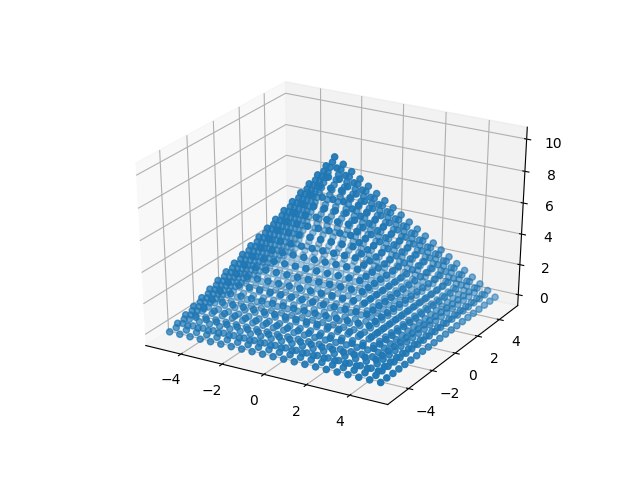

3606 points


In [89]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pyramid = create_pyramid(ground_length=10,height=10,grid_size=0.5)
pyramid += 0.001*np.random.randn(*pyramid.shape)
ax.scatter(pyramid[:,0],pyramid[:,1],pyramid[:,2])
print(pyramid.size,'points')

In [161]:
MG = base.Meshgrid(pyramid)
diag = np.linalg.norm(np.min(pyramid,axis=0) - np.max(pyramid,axis=0))
#print('Max_dist:',max_dist)
#MG.compute_all_harris_responses(neigh_flag='ring', neigh_args={'max_dist':max_dist}, k_harris=0.04)
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':50}, k_harris=0.04)
#MG.compute_all_harris_responses(neigh_flag='dist', neigh_args={'distance':0.15}, k_harris=0.04)

harris_values = MG.harris_values
print('min harris   ',np.min(harris_values))
print('median harris',np.median(harris_values))
print('max harris   ',np.max(harris_values))

min harris    -1.0180028665093506
median harris 2.4687119148244223e-15
max harris    4.0154749811733215


<IPython.core.display.Javascript object>


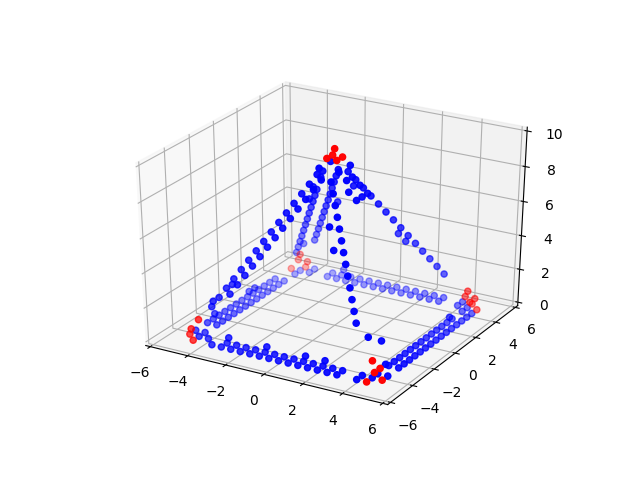

(0, 10)

In [162]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.2*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.98*len(harris_values)):int(1.0*len(harris_values))]
pyramid_smallest = pyramid[indices_smallest]
pyramid_largest = pyramid[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_smallest[:,0],pyramid_smallest[:,1],pyramid_smallest[:,2],c='b')
ax.scatter(pyramid_largest[:,0],pyramid_largest[:,1],pyramid_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(-0,10)

<IPython.core.display.Javascript object>


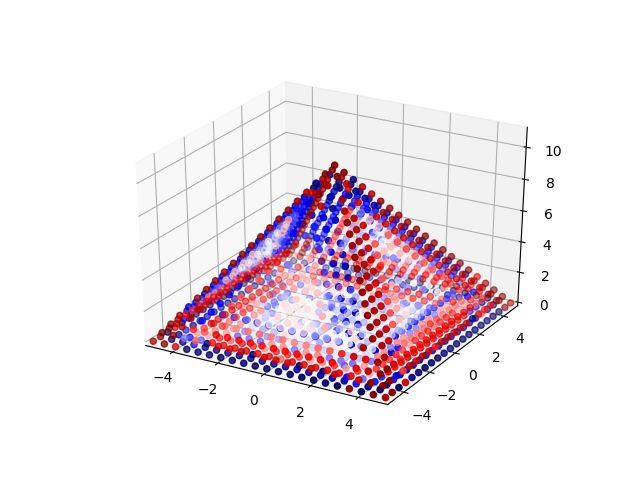

(0, 11)

In [163]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
pyramid_new = pyramid[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=np.linspace(0,1,len(pyramid_new)),cmap='seismic')
#ax.scatter(pyramid_new[:,0],pyramid_new[:,1],pyramid_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-0,11)


### Cube

<IPython.core.display.Javascript object>


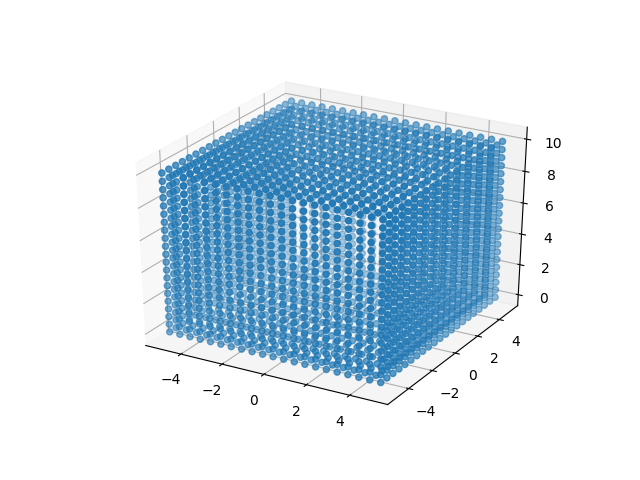

7206 points


In [182]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cube = create_cube(edge_length=10,grid_size=0.5)
cube += 0.001*np.random.randn(*cube.shape)
ax.scatter(cube[:,0],cube[:,1],cube[:,2])
print(cube.size,'points')

In [178]:
MG = base.Meshgrid(cube)
diag = np.linalg.norm(np.min(cube,axis=0) - np.max(cube,axis=0))
max_dist = 0.1*diag
#print('Max_dist:',max_dist)
#MG.compute_all_harris_responses(neigh_flag='ring', neigh_args={'max_dist':max_dist}, k_harris=0.04)
MG.compute_all_harris_responses(neigh_flag='k', neigh_args={'k':50}, k_harris=0.04)
#MG.compute_all_harris_responses(neigh_flag='dist', neigh_args={'distance':0.15}, k_harris=0.04)

harris_values = MG.harris_values
print('min harris   ',np.min(harris_values))
print('median harris',np.median(harris_values))
print('max harris   ',np.max(harris_values))

min harris    -0.0715582464093876
median harris 8.66902031993176e-17
max harris    0.4041158765199176


<IPython.core.display.Javascript object>


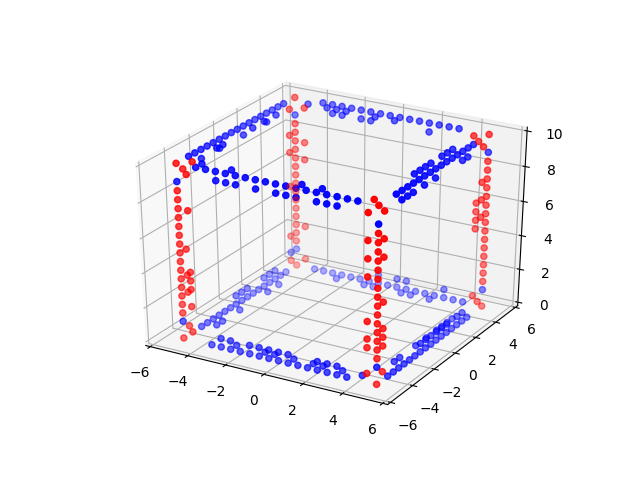

(0, 10)

In [179]:
indices_smallest = np.argsort(harris_values)[int(0.0*len(harris_values)):int(0.1*len(harris_values))]
indices_largest = np.argsort(harris_values)[int(0.95*len(harris_values)):int(1.0*len(harris_values))]
cube_smallest = cube[indices_smallest]
cube_largest = cube[indices_largest]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_smallest[:,0],cube_smallest[:,1],cube_smallest[:,2],c='b')
ax.scatter(cube_largest[:,0],cube_largest[:,1],cube_largest[:,2],c='r')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)

<IPython.core.display.Javascript object>


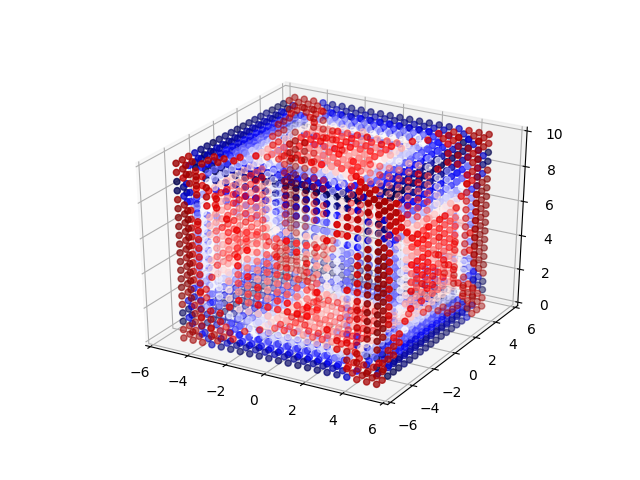

(0, 10)

In [177]:
indices = np.argsort(harris_values)[int(0*len(harris_values)):int(1.0*len(harris_values))]
cube_new = cube[indices]
harris_new = harris_values[indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=np.linspace(0,1,len(cube_new)),cmap='seismic')
#ax.scatter(cube_new[:,0],cube_new[:,1],cube_new[:,2],c=harris_new,cmap='seismic')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(0,10)
